In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

def Adversarial_Validation(train_df,test_df,target_name,*, test_contains_target = False, cat_cols = None):
    """ Проверка того, из одного ли распределения взяты данные на трейне или на тесте. 
    Идея в том, что если мы таргетом сделаем "тестовый объект" или "обучающий объект",
    то модель должна плохо различать эти данные в случае если их распределения не
    различаются и метрика (в данном случае roc auc) будет не сильно лучше чем у случайного предсказания (0.5)
    """

    train = train_df.copy()
    test = test_df.copy()
    train = train.drop(target_name,axis = 1)
    if test_contains_target:
        test = test.drop(target_name,axis = 1)
    
    train["AV_label"] = 0
    test["AV_label"]  = 1

    if cat_cols == None:
        cat_cols = train.select_dtypes(['object']).columns.to_list()

    all_data = pd.concat([train, test], axis=0, ignore_index=True)

    all_data_shuffled = all_data.sample(frac=1, random_state=52).reset_index(drop=True)

    y = all_data_shuffled['AV_label']
    X = all_data_shuffled.drop(['AV_label'], axis=1)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)
    importances = []
    auc_scores = []

    for train_idx, val_idx in skf.split(X, y):
        print('Doing fold')
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        params = {
        'eval_metric' : "AUC",
        'cat_features': cat_cols,
        'use_best_model': True,
        'early_stopping_rounds': 200,
        'random_seed': 52,
        'verbose': False
        }
        
        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val))
        importances.append(model.get_feature_importance())
        y_pred_proba = model.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred_proba)
        auc_scores.append(auc)
        print('AUC score on fold :',auc,end = "\n\n")

    # Усредняем важности по фолдам
    mean_importance = np.mean(importances, axis=0)
    std_importance = np.std(importances,axis = 0)
    feature_names = X.columns

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': mean_importance,
        'std': std_importance
    }).sort_values('importance', ascending=False)

    features = importance_df['feature']
    importances = importance_df['importance']
    stds = importance_df['std']

    y_pos = np.arange(len(features))

    plt.figure(figsize=(12, 8))
    bars = plt.barh(y_pos, importances, xerr=stds, align='center', alpha=0.8, capsize=4, error_kw={'ecolor': 'red', 'elinewidth': 1})

    for i, (imp, std) in enumerate(zip(importances, stds)):
        plt.text(
            imp + std + max(importances) * 0.01,
            i,
            f'{imp:.4f} +- {std:.4f}',
            va='center',
            ha='left',
            fontsize=9
        )

    plt.yticks(y_pos, features)
    plt.xlabel('Feature Importance (mean ± std)')
    plt.title('CatBoost Feature Importances (with std across CV folds)')
    plt.gca().invert_yaxis()  
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    print("AUC values:",*auc_scores)
    print("mean AUC",np.mean(auc_scores))
    plt.show()


In [2]:
target = "diagnosed_diabetes"
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Doing fold
AUC score on fold : 0.999998958095238

Doing fold
AUC score on fold : 0.9999998598809525

Doing fold
AUC score on fold : 0.9999970908333334

Doing fold
AUC score on fold : 0.999995414702381

Doing fold
AUC score on fold : 0.9999919143452382

AUC values: 0.999998958095238 0.9999998598809525 0.9999970908333334 0.999995414702381 0.9999919143452382
mean AUC 0.9999966475714286


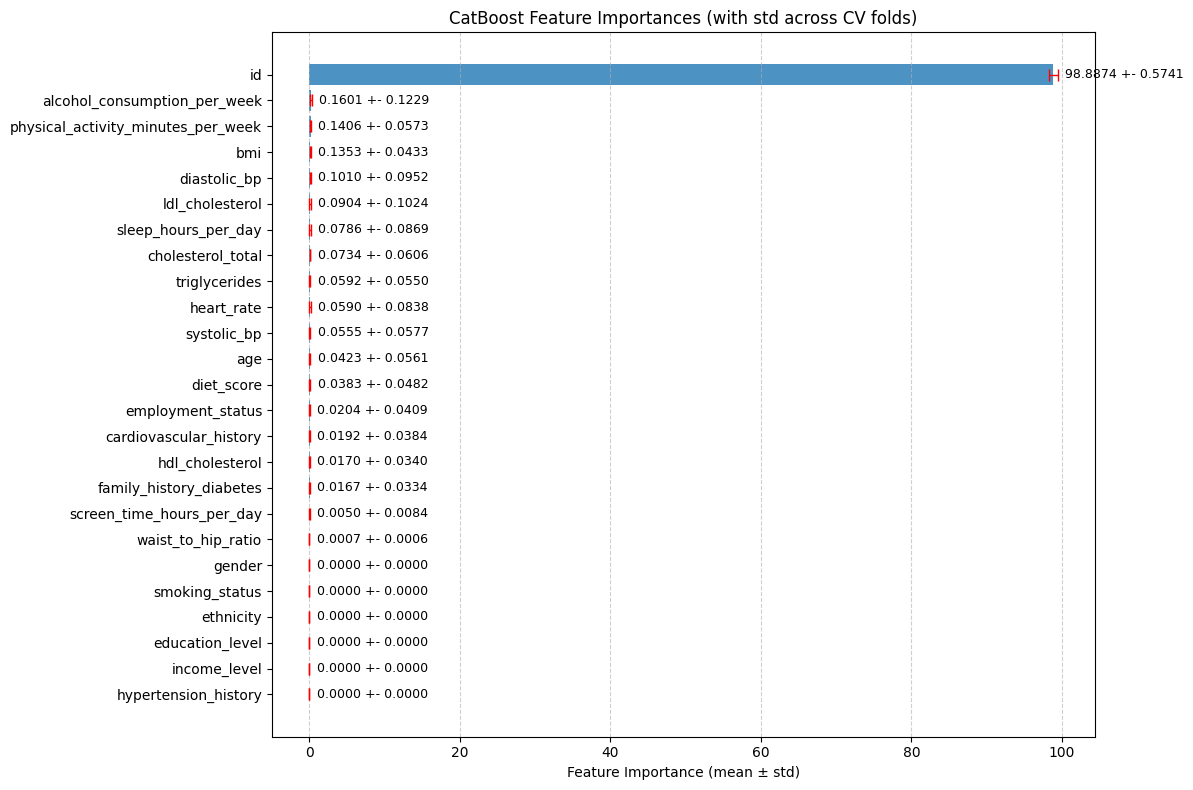

In [3]:
Adversarial_Validation(train,test,target)

Doing fold
AUC score on fold : 0.6406015395238094

Doing fold
AUC score on fold : 0.6409198503571427

Doing fold
AUC score on fold : 0.6401399522619048

Doing fold
AUC score on fold : 0.6401975946428571

Doing fold
AUC score on fold : 0.6389510276190477

AUC values: 0.6406015395238094 0.6409198503571427 0.6401399522619048 0.6401975946428571 0.6389510276190477
mean AUC 0.6401619928809523


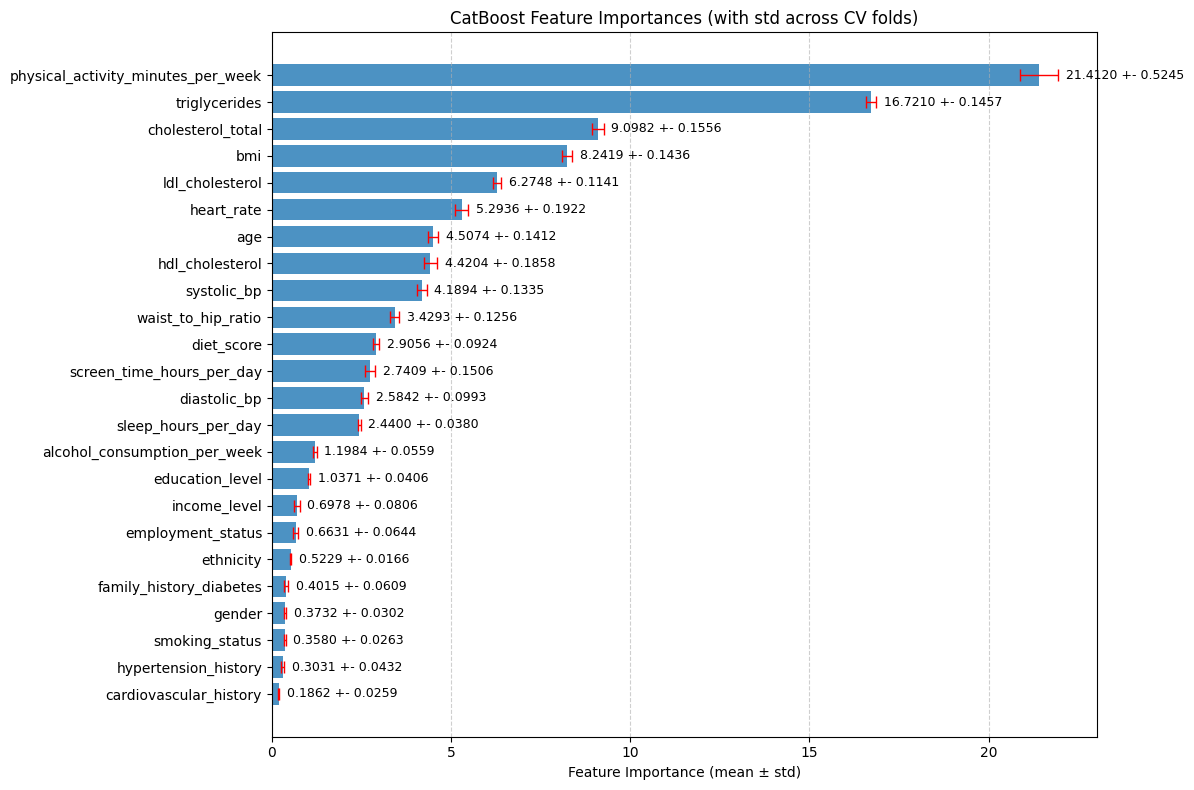

In [4]:
train_no_id = train.drop("id",axis=1)
test_no_id = test.drop("id",axis=1)
Adversarial_Validation(train_no_id,test_no_id,target)

In [5]:
test.select_dtypes(np.number).columns.values.tolist()

['id',
 'age',
 'alcohol_consumption_per_week',
 'physical_activity_minutes_per_week',
 'diet_score',
 'sleep_hours_per_day',
 'screen_time_hours_per_day',
 'bmi',
 'waist_to_hip_ratio',
 'systolic_bp',
 'diastolic_bp',
 'heart_rate',
 'cholesterol_total',
 'hdl_cholesterol',
 'ldl_cholesterol',
 'triglycerides',
 'family_history_diabetes',
 'hypertension_history',
 'cardiovascular_history']

In [6]:
from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp

drifted_features = []
def compare_numeric_distributions(train,test,shift_features):
    num_features_list = test.select_dtypes(np.number).columns.values.tolist()
    for feature in num_features_list:
        result = ks_2samp(train[feature], test[feature])
        # statistic - максимальная абсолютная разница между величинами распределений
        # p-value - индикатор насколько верна нулевая гипотеза. 


        # В данном случае
        # нулевая гипотеза - два датасета взяты из одного и того же распределения.
        # альтернативная гипотеза - два датасета взяты из разных распределений.
        # порог при котором нулевая гипотеза перестает быть верной - 0.05
        # метод наиболее подходит если датасеты всего в несколько тысяч объектов, но вместе с feature importance
        # можно сделать окончательный вывод
        if result.statistic > 0.1 and result.pvalue < 0.05:
            print(f"KS test value: {result.statistic} with a p-value {result.pvalue} for the feature {feature}")
            shift_features.append(feature) 

def compare_categorical_distributions(df1, df2, categorical_columns,shift_features, alpha=0.05,):
    results = []

    for col in categorical_columns:
        if col not in df1.columns or col not in df2.columns:
            raise ValueError(f"Колонка '{col}' отсутствует в одном из датафреймов.")
        
        # Получаем все возможные категории (объединяем уникальные значения)
        all_categories = sorted(set(df1[col].dropna().unique()) | set(df2[col].dropna().unique()))
        
        # Преобразуем в категориальные с фиксированными уровнями для корректного подсчёта
        s1 = pd.Categorical(df1[col], categories=all_categories)
        s2 = pd.Categorical(df2[col], categories=all_categories)
        
        # Считаем частоты
        counts1 = pd.Series(s1).value_counts(sort=False).reindex(all_categories, fill_value=0).values
        counts2 = pd.Series(s2).value_counts(sort=False).reindex(all_categories, fill_value=0).values
        
        # Формируем таблицу сопряжённости
        contingency_table = np.array([counts1, counts2])
        
        # Проверяем, что нет столбцов/строк с нулевой суммой (иначе chi2 не применим)
        if (contingency_table.sum(axis=0) == 0).any() or (contingency_table.sum(axis=1) == 0).any():
            # Пропускаем или помечаем как некорректный
            results.append({
                'column': col,
                'chi2': np.nan,
                'p_value': np.nan,
                'dof': np.nan,
                'same_distribution': np.nan,
                'note': 'Недостаточно данных (нулевые строки/столбцы)'
            })
            continue
            # p - вероятность наблюдать такие различия при условии что нулевая гипотеза верна (распределения одинаковы). Если выше 0.05 - распределения скорее всего одинаковые
        try:
            chi2, p, dof, _ = chi2_contingency(contingency_table)
            same_dist = p >= alpha
            note = ''
        except Exception as e:
            chi2, p, dof, same_dist, note = np.nan, np.nan, np.nan, np.nan, str(e)

        results.append({
            'column': col,
            'chi2': chi2,
            'p_value': p,
            'dof': dof,
            'same_distribution': same_dist,
            'note': note
        })
        if not same_dist:
            shift_features.append(col)
    
    return pd.DataFrame(results)
compare_numeric_distributions(train,test,drifted_features)
cat_cols = ["alcohol_consumption_per_week","gender","ethnicity", "education_level","income_level","smoking_status","employment_status","family_history_diabetes",\
            "hypertension_history","cardiovascular_history"]
results = compare_categorical_distributions(train, test, cat_cols,drifted_features, alpha=0.05)

print(f"Всего со сдвигом {len(drifted_features)} признаков:{drifted_features}")
# p - вероятность наблюдать такие различия при условии что нулевая гипотеза верна (распределения одинаковы). Если выше 0.05 - распределения скорее всего одинаковые

KS test value: 1.0 with a p-value 0.0 for the feature id
KS test value: 0.10592333333333337 with a p-value 0.0 for the feature physical_activity_minutes_per_week
Всего со сдвигом 12 признаков:['id', 'physical_activity_minutes_per_week', 'alcohol_consumption_per_week', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']


In [7]:
drifted_features = ['physical_activity_minutes_per_week']
for feature in drifted_features:

    train_vals = train[feature].values
    test_vals = test[feature].values
    N_BINS = 300

    # Задаем частоту корзин, иначе говоря получаем перцентили распределения тестового массива.
    # Каждое значение полученное значение будет границей интерваал корзины
    step = 100 / N_BINS

    test_percentiles = [
        np.percentile(test_vals, q, axis=0)
        for q in np.arange(start=step, stop=100, step=step)
    ]

    # Присваиваем каждой коризне набор объектов. 
    # Функция возвращает индекс корзины, в которое входит значение
    train_bins = np.digitize(train_vals, test_percentiles)

    # Считаем количество объектов в каждой корзине или сколько индекс i из входного массива,
    # где 0 будет соответствовать количеству вхождений индекса нуль, 1 количеству вхождений индекса 1 и так до i индекса
    train_bin_counts = np.bincount(train_bins)

    # Считаем веса каждого объекта, единица делится на количество вхождений объектов в корзине
    weights = 1 / np.array([train_bin_counts[x] for x in train_bins])

    # Нормируем веса так, чтобы их сумма равнялась единице
    weights_norm = weights / weights.sum()

    np.random.seed(52)

    n_samples = int(len(train_vals) * 0.2) 
    selected_indices = np.random.choice(np.arange(len(train_vals)),size=n_samples,p=weights_norm,replace=True)
    train_remaining = train[train.index.isin(selected_indices)].reset_index(drop=True)
    

Doing fold
AUC score on fold : 0.6496272285872482

Doing fold
AUC score on fold : 0.6495203209960674

Doing fold
AUC score on fold : 0.6480348098300609

Doing fold
AUC score on fold : 0.6501874994676093

Doing fold
AUC score on fold : 0.6495424574779225

AUC values: 0.6496272285872482 0.6495203209960674 0.6480348098300609 0.6501874994676093 0.6495424574779225
mean AUC 0.6493824632717817


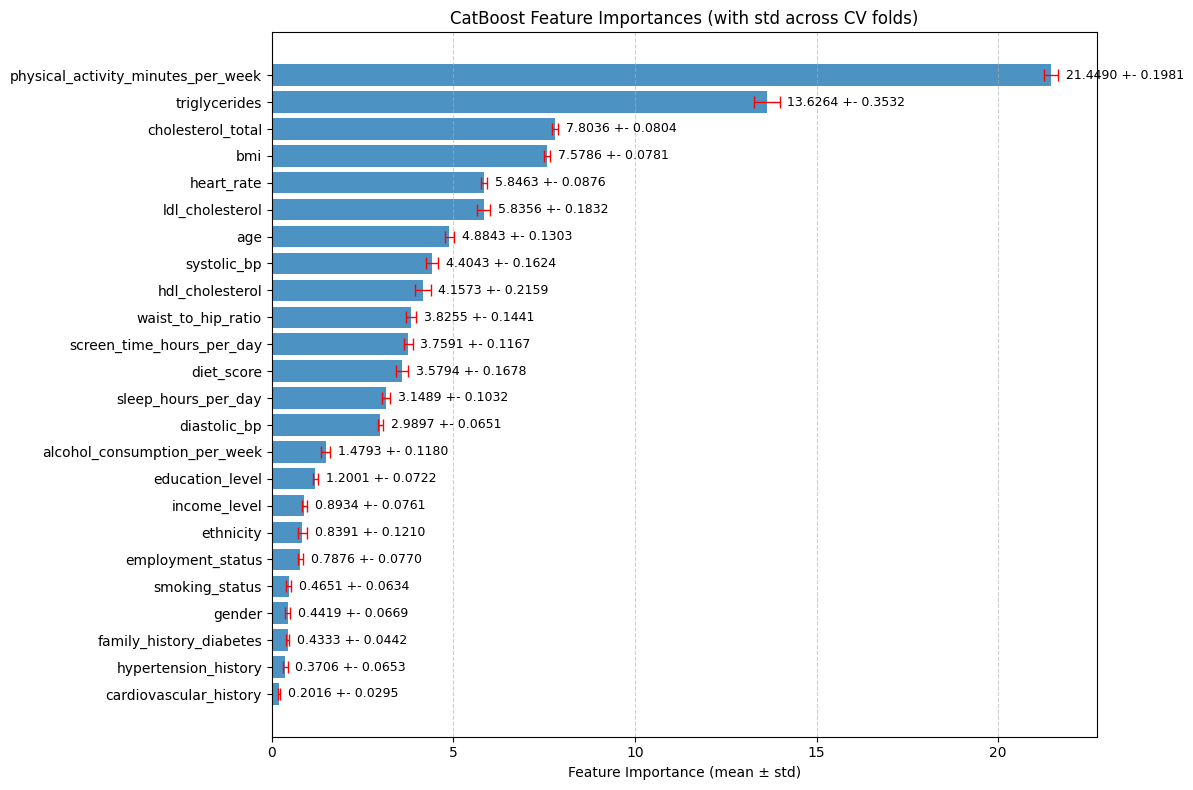

In [8]:
Adversarial_Validation(train_remaining.drop("id",axis=1),test.drop("id",axis =1),target)